🔄 Loading FDES Database...
✅ Database loaded: 20 products available.

🚀 RUNNING CARBON SIMULATION

🏗️ Analyzing System: Lattice (LEKO 5L180)
   🔹 Mur en bois 5L180... : Area Ratio 1.00
   🔹 GUTEX Thermowall-L® m]... : Area Ratio 1.00
   👉 Total Carbon Weight: -42.1 kgCO2eq/m²

🏗️ Analyzing System: CLT (Massive 140mm)
   🔹 Panneau CLT (lamellé-croisé), ... : Converted Thickness 0.14m -> Volume 0.140 m3
   🔹 GUTEX Thermowall-L® m]... : Area Ratio 1.00
   👉 Total Carbon Weight: -39.9 kgCO2eq/m²

🏗️ Analyzing System: Concrete (Béton 180mm)
   🔹 Mur extérieur en béton d'épais... : Area Ratio 1.00
   🔹 GUTEX Thermowall-L® m]... : Area Ratio 1.00
   👉 Total Carbon Weight: 45.7 kgCO2eq/m²

📊 FINAL RESULTS: Carbon Weight per m² Wall
| System                 |   Production (A1-A5) |   EOL + Benefits (Weighted) |   Total Impact (kgCO2eq/m²) |
|:-----------------------|---------------------:|----------------------------:|----------------------------:|
| Lattice (LEKO 5L180)   |                -59.

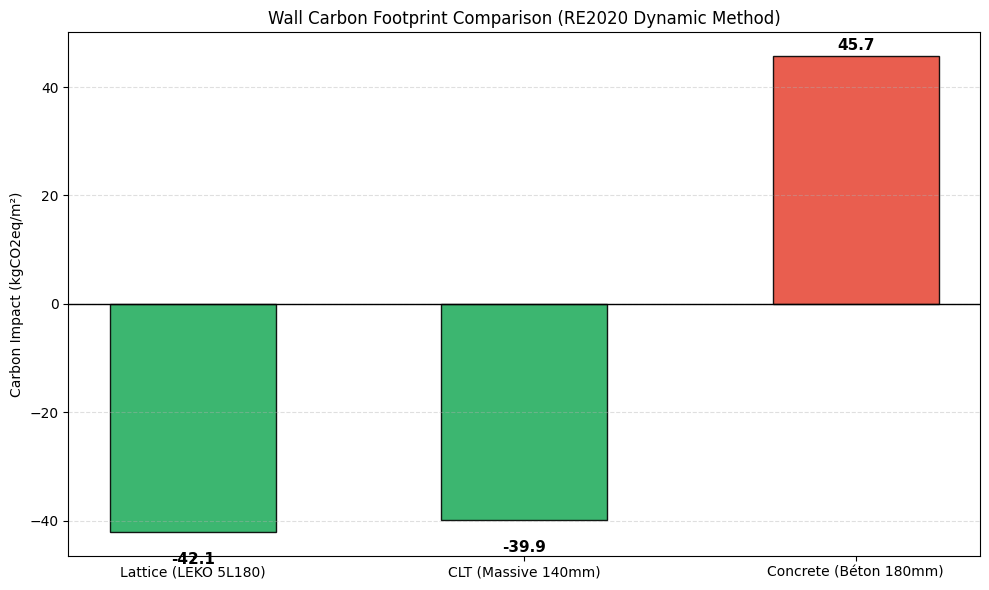

In [12]:
"""
# Carbon Footprint Assessment (RE2020 Dynamic Component Method)
Comparative Life Cycle Assessment of wall assemblies (1 m² of wall).

Objective:
Compare the Carbon Weight (kgCO2eq/m²_wall) of 3 structural systems:
1. Lattice System (Wood + Fibre)
2. CLT System (Massive Wood)
3. Concrete System (Masonry)

Methodology (RE2020 Style):
- Dynamic LCA approach for the component.
- "Carbon Weight" = Sum(Production A1-A5) + 0.578 * Sum(End of Life C1-C4 + D)
- Biogenic carbon credits are included in Module D.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# PART 1: LOAD DATABASE
# ============================================================================

print("🔄 Loading FDES Database...")
try:
    df_uf = pd.read_excel('db_carbon.xlsx', sheet_name='UF')
    df_gwp = pd.read_excel('db_carbon.xlsx', sheet_name='indicateur')
    print(f"✅ Database loaded: {len(df_uf)} products available.")
except FileNotFoundError:
    print("❌ Error: 'db_carbon.xlsx' missing.")

# ============================================================================
# PART 2: CALCULATION ENGINE
# ============================================================================

def get_product_data(product_name_exact):
    row_gwp = df_gwp[df_gwp['Nom du produit'] == product_name_exact].iloc[0]
    row_uf = df_uf[df_uf['Nom du produit'] == product_name_exact].iloc[0]
    return row_gwp, row_uf

def calculate_wall_impact(wall_config, system_name):
    """
    Calculates the Carbon Weight of 1 m² of wall.
    """
    print(f"\n🏗️ Analyzing System: {system_name}")
    
    total_a1_a5 = 0
    total_c1_c4_d = 0
    components = []
    
    for prod_name, qty_req, unit_req in wall_config:
        gwp, uf = get_product_data(prod_name)
        
        # Robust conversion
        try:
            raw_qty = str(uf['Quantité']).replace(',', '.')
            uf_val = float(raw_qty)
        except ValueError:
            uf_val = 1.0

        uf_unit = str(uf['Unité fonctionnelle (U.F.)'])
        
        # Scaling Logic
        scale = 1.0
        if 'm3' in uf_unit and unit_req == 'm2': # Need Volume from Thickness
            scale = (1.0 * qty_req) / uf_val
            print(f"   🔹 {prod_name[:30]}... : Converted Thickness {qty_req}m -> Volume {scale:.3f} m3")
        elif 'm²' in uf_unit or 'm2' in uf_unit:
            scale = qty_req / uf_val
            print(f"   🔹 {prod_name[:30]}... : Area Ratio {scale:.2f}")
        else:
            print(f"   ⚠️ Unit Mismatch for {prod_name}, assuming scale=1.0")

        # Phases
        a_sum = (gwp['A1 / A2 / A3'] + gwp['A4 Transport'] + gwp['A5 Installation']) * scale
        
        # End of Life (C) + Module D (Benefits)
        # Note: Module D is negative for wood (carbon credit)
        end_sum = (gwp['C1 Déconstruction / démoliton'] + gwp['C2 Transport'] + 
                   gwp['C3 Traitement des déchets'] + gwp['C4 Élimination'] + 
                   gwp['D Bénéfices et charges au-delà des frontières du système']) * scale
        
        total_a1_a5 += a_sum
        total_c1_c4_d += end_sum
        
        components.append({
            'Product': prod_name[:40],
            'A1-A5 (Prod)': a_sum,
            'C1-C4+D (EOL)': end_sum,
            'Weighted EOL (0.578)': 0.578 * end_sum
        })

    # RE2020 Dynamic Aggregation
    carbon_weight = total_a1_a5 + (0.578 * total_c1_c4_d)
    
    print(f"   👉 Total Carbon Weight: {carbon_weight:.1f} kgCO2eq/m²")
    
    return {
        'system': system_name,
        'carbon_weight': carbon_weight,
        'prod_phase': total_a1_a5,
        'eol_phase_weighted': 0.578 * total_c1_c4_d,
        'components': pd.DataFrame(components)
    }

# ============================================================================
# PART 3: SCENARIOS
# ============================================================================

# 1. LATTICE (Optimized)
lattice_cfg = [
    ('Mur en bois 5L180', 1.0, 'm2'),
    ('GUTEX Thermowall-L® [145mm]', 1.0, 'm2')
]

# 2. CLT (Massive)
# 140mm CLT Wall
clt_cfg = [
    ('Panneau CLT (lamellé-croisé), fabriqué en France', 0.14, 'm2'), # 0.14m thickness
    ('GUTEX Thermowall-L® [145mm]', 1.0, 'm2')
]

# 3. CONCRETE (Standard)
# 180mm Concrete Wall
conc_cfg = [
    ("Mur extérieur en béton d'épaisseur 0.18 m, C25/30 XC4 / XF1 CEM II/A", 1.0, 'm2'),
    ('GUTEX Thermowall-L® [145mm]', 1.0, 'm2')
]

# ============================================================================
# PART 4: REPORT
# ============================================================================

print("\n" + "="*60)
print("🚀 RUNNING CARBON SIMULATION")
print("="*60)

res_lat = calculate_wall_impact(lattice_cfg, "Lattice (LEKO 5L180)")
res_clt = calculate_wall_impact(clt_cfg, "CLT (Massive 140mm)")
res_conc = calculate_wall_impact(conc_cfg, "Concrete (Béton 180mm)")

# Results Table
df_res = pd.DataFrame([
    {
        "System": res_lat['system'],
        "Production (A1-A5)": res_lat['prod_phase'],
        "EOL + Benefits (Weighted)": res_lat['eol_phase_weighted'],
        "Total Impact (kgCO2eq/m²)": res_lat['carbon_weight']
    },
    {
        "System": res_clt['system'],
        "Production (A1-A5)": res_clt['prod_phase'],
        "EOL + Benefits (Weighted)": res_clt['eol_phase_weighted'],
        "Total Impact (kgCO2eq/m²)": res_clt['carbon_weight']
    },
    {
        "System": res_conc['system'],
        "Production (A1-A5)": res_conc['prod_phase'],
        "EOL + Benefits (Weighted)": res_conc['eol_phase_weighted'],
        "Total Impact (kgCO2eq/m²)": res_conc['carbon_weight']
    }
])

print("\n" + "="*60)
print("📊 FINAL RESULTS: Carbon Weight per m² Wall")
print("="*60)
print(df_res.to_markdown(index=False, floatfmt=".1f"))

# ============================================================================
# PART 5: VISUALIZATION
# ============================================================================

plt.figure(figsize=(10, 6))
systems = df_res['System']
impacts = df_res['Total Impact (kgCO2eq/m²)']

# Color Logic: Green (Negative/Low), Yellow (Mid), Red (High)
colors = []
for val in impacts:
    if val < 0: colors.append('#27ae60') # Super Green
    elif val < 10: colors.append('#2ecc71') # Green
    else: colors.append('#e74c3c') # Red

bars = plt.bar(systems, impacts, color=colors, width=0.5, edgecolor='black', alpha=0.9)

plt.axhline(0, color='black', linewidth=1)
plt.ylabel('Carbon Impact (kgCO2eq/m²)')
plt.title('Wall Carbon Footprint Comparison (RE2020 Dynamic Method)')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add Values on bars
for bar in bars:
    height = bar.get_height()
    y_pos = height - 5 if height < 0 else height + 2
    plt.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{height:.1f}', ha='center', va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()


In [9]:
df_uf[df_uf['Nom du produit']=='GUTEX Thermowall-L® [145mm]']

,Nom du produit,Organisme déclarant,Famille de produit INIES,Catégorie,Base de données d'arrière plan,Norme environnementale,Unité fonctionnelle (U.F.),Quantité,Durée de vie de référence (DVR),Distances de transport,Poids de l'UF,Quantité de biosourcés (kg),Carbone biogénqiue stocké (kg eq. de CO2),Description du produit,Produits couverts
12,GUTEX Thermowall-L® [145mm],GUTEX,Isolants thermiques et acoustiques pour murs (...,Isolant,Ecoinvent,NF EN 15804+A1,Assurer une fonction d’isolation thermique sur...,m2,50 ans,A4 (scénario) : 500 kms \nC2 déchets recyclés ...,NaN,NaN,25.93,NaN,NaN



🌳 BIOGENIC CARBON STORAGE ANALYSIS
| System           |   Stored Carbon |
|:-----------------|----------------:|
| Lattice (LEKO)   |            92.3 |
| CLT (Massive)    |           126.2 |
| Concrete (Béton) |            25.9 |


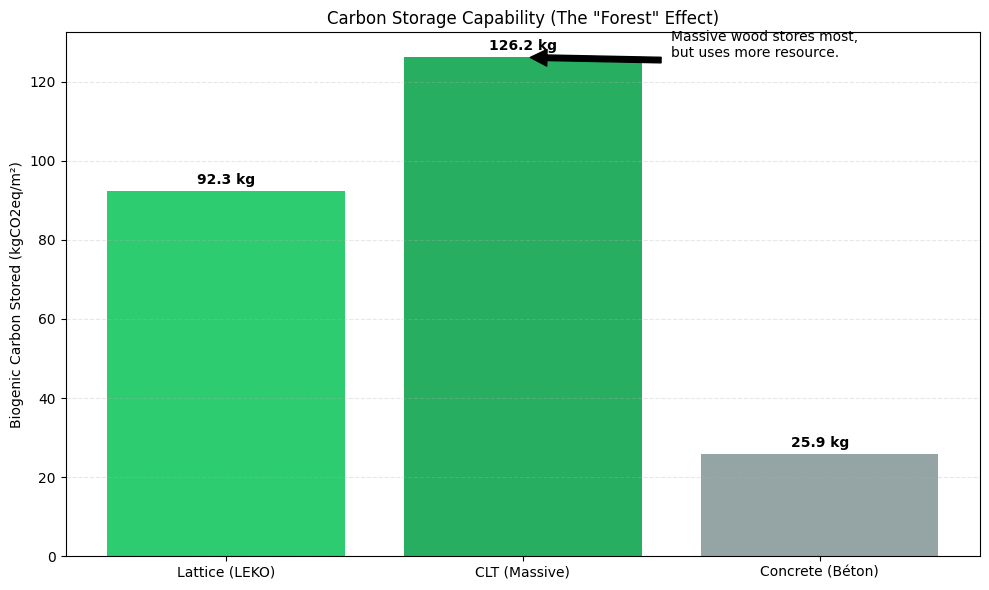

In [23]:
# ============================================================================
# PART 6: BIOGENIC CARBON STORAGE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("🌳 BIOGENIC CARBON STORAGE ANALYSIS")
print("="*60)

def get_biogenic_storage(wall_config, system_name):
    """
    Extracts the Biogenic Carbon Stored (kgCO2eq) for the wall.
    Note: In FDES, this is usually a positive number indicating the amount stored.
    """
    total_storage = 0
    
    for prod_name, qty_req, unit_req in wall_config:
        _, uf = get_product_data(prod_name)
        
        # Robust conversion (same as before)
        try:
            raw_qty = str(uf['Quantité']).replace(',', '.')
            uf_val = float(raw_qty)
        except ValueError:
            uf_val = 1.0

        uf_unit = str(uf['Unité fonctionnelle (U.F.)'])
        
        # Scaling
        scale = 1.0
        if 'm3' in uf_unit and unit_req == 'm2':
            scale = (1.0 * qty_req) / uf_val
        elif 'm²' in uf_unit or 'm2' in uf_unit:
            scale = qty_req / uf_val
            
        # Get Storage Value
        # Column name check in your Excel file
        col_bio = 'Carbone biogénqiue stocké (kg eq. de CO2)' # As per your print output earlier
        
        if col_bio in uf:
            storage = uf[col_bio]
            # Handle NaN or weird values
            if pd.isna(storage): storage = 0
            
            total_storage += storage * scale
            
    return total_storage

# Calculate Storage
bio_lat = get_biogenic_storage(lattice_cfg, "Lattice")
bio_clt = get_biogenic_storage(clt_cfg, "CLT")
bio_conc = get_biogenic_storage(conc_cfg, "Concrete")

# Create DataFrame
df_bio = pd.DataFrame([
    {"System": "Lattice (LEKO)", "Stored Carbon": bio_lat},
    {"System": "CLT (Massive)", "Stored Carbon": bio_clt},
    {"System": "Concrete (Béton)", "Stored Carbon": bio_conc}
])

print(df_bio.to_markdown(index=False, floatfmt=".1f"))

# Visualization
plt.figure(figsize=(10, 6))

# Plot
bars = plt.bar(df_bio['System'], df_bio['Stored Carbon'], color=['#2ecc71', '#27ae60', '#95a5a6'])

plt.ylabel('Biogenic Carbon Stored (kgCO2eq/m²)')
plt.title('Carbon Storage Capability (The "Forest" Effect)')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add Values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f} kg', ha='center', va='bottom', fontweight='bold')

# Annotation for Context
plt.annotate('Massive wood stores most,\nbut uses more resource.', 
             xy=(1, bio_clt), xytext=(1.5, bio_clt),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()



🌳 BIOGENIC STORAGE BREAKDOWN (Per Layer)


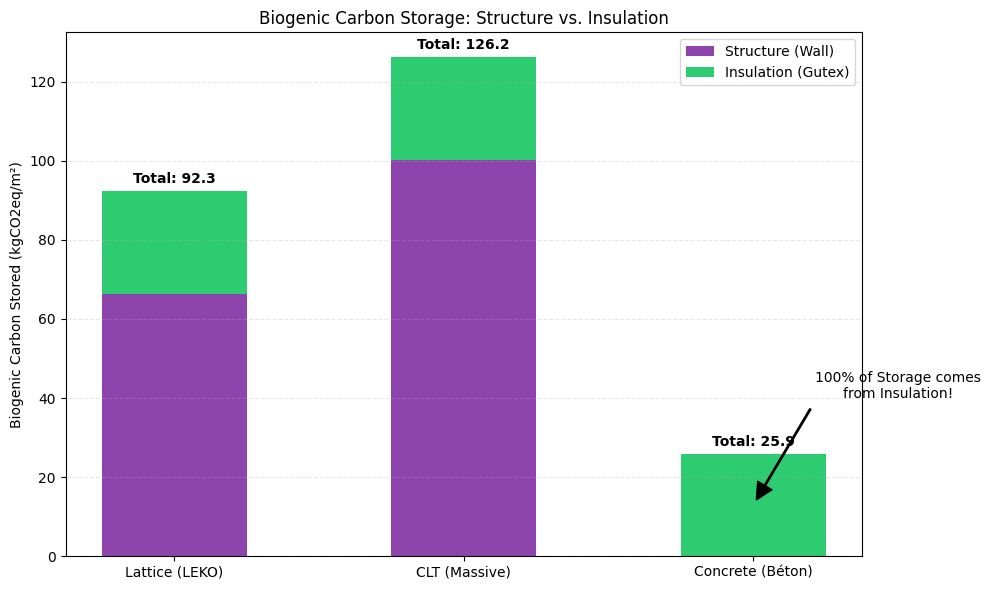

💡 INSIGHT:
- Lattice: Balanced storage between Structure (66.4) and Insulation (25.9).
- Concrete: Structure stores NOTHING (0.0). Only the Gutex saves the score.


In [24]:
# ============================================================================
# PART 6: BIOGENIC CARBON STORAGE BREAKDOWN (Stacked)
# ============================================================================

print("\n" + "="*60)
print("🌳 BIOGENIC STORAGE BREAKDOWN (Per Layer)")
print("="*60)

def get_biogenic_breakdown(wall_config, system_name):
    """
    Returns a dictionary of stored carbon per component.
    """
    breakdown = {}
    total = 0
    
    for prod_name, qty_req, unit_req in wall_config:
        _, uf = get_product_data(prod_name)
        
        # Robust conversion
        try:
            raw_qty = str(uf['Quantité']).replace(',', '.')
            uf_val = float(raw_qty)
        except ValueError:
            uf_val = 1.0
        
        # Scaling
        uf_unit = str(uf['Unité fonctionnelle (U.F.)'])
        scale = 1.0
        if 'm3' in uf_unit and unit_req == 'm2':
            scale = (1.0 * qty_req) / uf_val
        elif 'm²' in uf_unit or 'm2' in uf_unit:
            scale = qty_req / uf_val
            
        # Get Storage
        col_bio = 'Carbone biogénqiue stocké (kg eq. de CO2)'
        if col_bio in uf and pd.notna(uf[col_bio]):
            val = uf[col_bio] * scale
        else:
            val = 0
            
        # Shorten Name for Legend
        simple_name = "Structure" if ("Béton" in prod_name or "CLT" in prod_name or "5L180" in prod_name) else "Insulation (Gutex)"
        
        breakdown[simple_name] = val
        total += val
        
    return breakdown

# Get Breakdowns
bk_lat = get_biogenic_breakdown(lattice_cfg, "Lattice")
bk_clt = get_biogenic_breakdown(clt_cfg, "CLT")
bk_conc = get_biogenic_breakdown(conc_cfg, "Concrete")

# Prepare Data for Plotting
systems = ['Lattice (LEKO)', 'CLT (Massive)', 'Concrete (Béton)']
# Extract values ensuring order
struct_vals = [bk_lat.get('Structure', 0), bk_clt.get('Structure', 0), bk_conc.get('Structure', 0)]
ins_vals = [bk_lat.get('Insulation (Gutex)', 0), bk_clt.get('Insulation (Gutex)', 0), bk_conc.get('Insulation (Gutex)', 0)]

# Plotting
plt.figure(figsize=(10, 6))

# Stack 1: Structure (Wood/Concrete)
p1 = plt.bar(systems, struct_vals, color='#8e44ad', label='Structure (Wall)', width=0.5)

# Stack 2: Insulation (Gutex) - Sitting on top of Structure
p2 = plt.bar(systems, ins_vals, bottom=struct_vals, color='#2ecc71', label='Insulation (Gutex)', width=0.5)

plt.ylabel('Biogenic Carbon Stored (kgCO2eq/m²)')
plt.title('Biogenic Carbon Storage: Structure vs. Insulation')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add Total Labels
totals = [s + i for s, i in zip(struct_vals, ins_vals)]
for i, v in enumerate(totals):
    plt.text(i, v + 2, f"Total: {v:.1f}", ha='center', fontweight='bold')

# Annotation for Concrete
plt.annotate('100% of Storage comes\nfrom Insulation!', 
             xy=(2, ins_vals[2]/2), xytext=(2.5, 40),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             ha='center')

plt.tight_layout()
plt.show()

print("💡 INSIGHT:")
print(f"- Lattice: Balanced storage between Structure ({struct_vals[0]:.1f}) and Insulation ({ins_vals[0]:.1f}).")
print(f"- Concrete: Structure stores NOTHING ({struct_vals[2]:.1f}). Only the Gutex saves the score.")


In [22]:
df_uf[df_uf['Nom du produit']=='Mur en bois 5L180']['Carbone biogénqiue stocké (kg eq. de CO2)']

3    66.36
Name: Carbone biogénqiue stocké (kg eq. de CO2), dtype: float64